In [2]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [4]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')
store = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Year']=pd.DatetimeIndex(data.Date).year
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday, Open
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
open = data[data['Open']==0].index
data.drop(open,inplace=True)


# 결측값 처리
data = data.dropna(axis=0)

# store,open 이름 제거
data = data.drop(['Open'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Year','Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
digital_data
# 표준화
scaler = MinMaxScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data=categorey_data, columns=onehotencoding_cols)


# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
data['StateHoliday_a'] = data['StateHoliday_a'].replace({True: 1, False: 0})
data

C:\Users\rlaeo\AppData\Local\Temp\ipykernel_15448\2535952681.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')


,Sales,Customers,CompetitionDistance,Year,Month,Day,Store,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.126664,0.075122,0.016482,1.0,0.545455,1.000000,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0.120815,0.073904,0.016482,1.0,0.545455,0.966667,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,0.115087,0.070790,0.016482,1.0,0.545455,0.933333,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0.120599,0.075799,0.016482,1.0,0.545455,0.900000,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0.146856,0.082837,0.016482,1.0,0.545455,0.866667,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842201,0.166181,0.063752,0.070280,0.0,0.000000,0.200000,1115,1,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
842202,0.114823,0.045885,0.070280,0.0,0.000000,0.133333,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
842203,0.109263,0.044126,0.070280,0.0,0.000000,0.100000,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
842204,0.103415,0.040606,0.070280,0.0,0.000000,0.066667,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [5]:
data = data.groupby('Store').get_group(610)
data

,Sales,Customers,CompetitionDistance,Year,Month,Day,Store,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
461024,0.101297,0.070790,0.008439,1.0,0.545455,1.000000,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
461025,0.101754,0.063617,0.008439,1.0,0.545455,0.966667,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
461026,0.107458,0.071332,0.008439,1.0,0.545455,0.933333,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
461027,0.116892,0.078370,0.008439,1.0,0.545455,0.900000,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
461028,0.146711,0.080130,0.008439,1.0,0.545455,0.866667,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461798,0.188251,0.112209,0.008439,0.0,0.000000,0.200000,610,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
461799,0.072345,0.052924,0.008439,0.0,0.000000,0.133333,610,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
461800,0.089914,0.069437,0.008439,0.0,0.000000,0.100000,610,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
461801,0.079517,0.061316,0.008439,0.0,0.000000,0.066667,610,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [6]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True)
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

train_data의 row : 623, column : 27


In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = 27,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7168      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [9]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=64,
                    epochs=50,
)

Epoch 1/50
10/10 [==============================] - 1s 25ms/step - loss: 1.3554 - mean_absolute_error: 0.9160 - val_loss: 7.9951 - val_mean_absolute_error: 2.8274
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 0.9545 - mean_absolute_error: 0.7776 - val_loss: 2.9298 - val_mean_absolute_error: 1.7115
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 0.8257 - mean_absolute_error: 0.7263 - val_loss: 1.7824 - val_mean_absolute_error: 1.3349
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7170 - mean_absolute_error: 0.6898 - val_loss: 1.2771 - val_mean_absolute_error: 1.1298
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6111 - mean_absolute_error: 0.6262 - val_loss: 0.9356 - val_mean_absolute_error: 0.9669
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 0.5684 - mean_absolute_error: 0.5993 - val_loss: 0.5782 - val_mean_absolute_error: 0.7600
Epoch 7/50
10/10 [=========

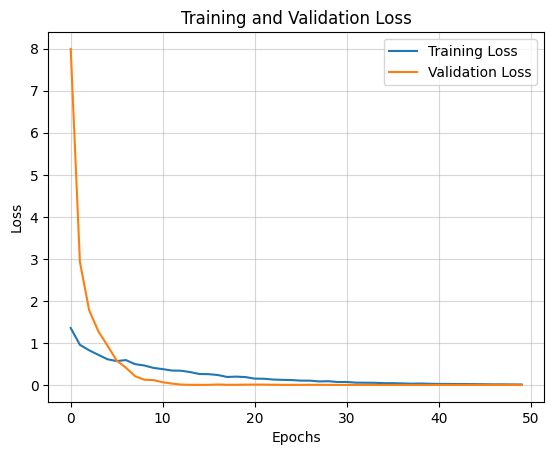

5/5 [==============================] - 0s 2ms/step - loss: 9.7726e-04 - mean_absolute_error: 0.0259

 Test Accuracy: 0.0259


In [11]:
import matplotlib.pyplot as plt
# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그리드 추가
plt.grid(True, linestyle='-', alpha=0.5)

plt.show()
print("\n Test Accuracy: %.4f" %(model.evaluate(x_test,y_test)[1]))